In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
df_balanced_new = pd.read_csv('/content/drive/MyDrive/archive/df_balanced.csv')

In [ ]:
df_balanced_new.head()

,Unnamed: 0,cc_num,merchant,category,amt,first,last,gender,street,city,...,job,trans_num,unix_time,merch_lat,merch_long,age,hour,day,month,is_fraud
0,0,2703186189652095,514,8,4.97,164,18,0,576,532,...,372,80326,1325376018,36.011293,-82.048315,37,0,1,1,0
1,1,630423337322,241,4,107.23,312,161,0,439,619,...,431,227462,1325376044,49.159047,-118.186462,47,0,1,1,0
2,2,38859492057661,390,0,220.11,116,386,1,610,474,...,308,1169030,1325376051,43.150704,-112.154481,63,0,1,1,0
3,3,3534093764340240,360,2,45.00,165,468,1,945,84,...,330,777909,1325376076,47.034331,-112.561071,58,0,1,1,0
4,4,375534208663984,297,9,41.96,339,153,1,422,217,...,116,1186866,1325376186,38.674999,-78.632459,39,0,1,1,0


In [ ]:
df_balanced_new.shape

(2764114, 25)

# **Dataset Seperation**

In [ ]:
# 🔹 Séparer les features et la cible
X = df_balanced_new.drop("is_fraud", axis=1)
y = df_balanced_new["is_fraud"]


In [ ]:
# 🔹 Séparation entraînement / test (stratifiée)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("✅ Données séparées avec succès :")
print(f"Train set : {X_train.shape}, Test set : {X_test.shape}")
print("Distribution (train) :", y_train.value_counts(normalize=True))
print("Distribution (test) :", y_test.value_counts(normalize=True))


✅ Données séparées avec succès :
Train set : (2073085, 24), Test set : (691029, 24)
Distribution (train) : is_fraud
0    0.666667
1    0.333333
Name: proportion, dtype: float64
Distribution (test) : is_fraud
0    0.666667
1    0.333333
Name: proportion, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
# 🔹 Normalisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# 🔹 Split data (entraînement/test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# 🔹 Définition du modèle Autoencoder Classifieur
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

In [ ]:
# 🧠 Encodeur
encoded = Dense(64, activation='relu', activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(16, activation='relu')(encoded)

In [ ]:
# 🔁 Décodeur
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
reconstruction = Dense(input_dim, activation='sigmoid', name="reconstruction")(decoded)


In [ ]:
# 🎯 Couche de classification
classification = Dense(8, activation='relu')(encoded)
classification = Dropout(0.2)(classification)
classification = Dense(1, activation='sigmoid', name="classification")(classification)


In [ ]:

# 🧩 Modèle combiné
autoencoder_classifier = Model(inputs=input_layer, outputs=[reconstruction, classification])
autoencoder_classifier.compile(
    optimizer=Adam(1e-3),
    loss={'reconstruction': 'mse', 'classification': 'binary_crossentropy'},
    loss_weights={'reconstruction': 0.7, 'classification': 1.0},
    metrics={'classification': 'accuracy'}
)

In [ ]:
# 🔹 Entraînement
history = autoencoder_classifier.fit(
    X_train, {'reconstruction': X_train, 'classification': y_train},
    validation_data=(X_test, {'reconstruction': X_test, 'classification': y_test}),
    epochs=20,
    batch_size=128,
    shuffle=True,
    verbose=1
)

Epoch 1/20
17276/17276 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - classification_accuracy: 0.8424 - classification_loss: 0.3639 - loss: 0.4041 - reconstruction_loss: 0.0540 - val_classification_accuracy: 0.9270 - val_classification_loss: 0.1895 - val_loss: 0.2199 - val_reconstruction_loss: 0.0415
Epoch 2/20
17276/17276 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - classification_accuracy: 0.9204 - classification_loss: 0.2232 - loss: 0.2583 - reconstruction_loss: 0.0481 - val_classification_accuracy: 0.9236 - val_classification_loss: 0.1885 - val_loss: 0.2185 - val_reconstruction_loss: 0.0403
Epoch 3/20
17276/17276 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - classification_accuracy: 0.9234 - classification_loss: 0.2124 - loss: 0.2472 - reconstruction_loss: 0.0474 - val_classification_accuracy: 0.9322 - val_classification_loss: 0.1689 - val_loss: 0.1989 - val_reconstruction_loss: 0.0405
Epoch 4/20
17276/17276 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - classification_accuracy: 0.9255 - classification_loss: 0.2058 - loss

In [ ]:
# 🔹 Évaluation du classifieur
_, _, classification_loss, classification_acc = autoencoder_classifier.evaluate(
    X_test, {'reconstruction': X_test, 'classification': y_test}, verbose=0
)

In [ ]:
# 🔍 Prédictions
_, y_pred_prob = autoencoder_classifier.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


17276/17276 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


In [ ]:

# 🔹 Évaluation
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))
print("🎯 AUC-ROC:", round(roc_auc_score(y_test, y_pred_prob), 4))

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95    368549
           1       0.95      0.85      0.90    184274

    accuracy                           0.94    552823
   macro avg       0.94      0.92      0.93    552823
weighted avg       0.94      0.94      0.94    552823

🎯 AUC-ROC: 0.9809


In [ ]:
# 🔍 Création d'un modèle intermédiaire pour obtenir les "deep features"
encoder_model = Model(inputs=autoencoder_classifier.input,
                      outputs=autoencoder_classifier.get_layer(index=5).output)  # couche encoded = index 5

# 🔹 Extraction des deep features
deep_features_train = encoder_model.predict(X_train)
deep_features_test = encoder_model.predict(X_test)

# 🔹 Concaténation avec les features originales (ML)
X_train_fused = np.concatenate([X_train, deep_features_train], axis=1)
X_test_fused = np.concatenate([X_test, deep_features_test], axis=1)

print("✅ Shape des features fusionnées :", X_train_fused.shape)


69103/69103 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step
17276/17276 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
✅ Shape des features fusionnées : (2211291, 40)


Fusion des features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import lightgbm as lgb
import xgboost as xgb

# 🔹 Initialisation des modèles
models = {
    "XGBoost": xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# 🔹 Entraînement + Évaluation
for name, model in models.items():
    print(f"\n🔷 Modèle : {name}")
    model.fit(X_train_fused, y_train)
    y_pred = model.predict(X_test_fused)
    y_prob = model.predict_proba(X_test_fused)[:, 1]

    print(classification_report(y_test, y_pred))
    print("🎯 AUC-ROC :", round(roc_auc_score(y_test, y_prob), 4))



🔷 Modèle : XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.96      0.98      0.97    368549
           1       0.96      0.91      0.94    184274

    accuracy                           0.96    552823
   macro avg       0.96      0.95      0.95    552823
weighted avg       0.96      0.96      0.96    552823

🎯 AUC-ROC : 0.9917

🔷 Modèle : Random Forest
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    368549
           1       0.97      0.89      0.93    184274

    accuracy                           0.95    552823
   macro avg       0.96      0.94      0.95    552823
weighted avg       0.95      0.95      0.95    552823

🎯 AUC-ROC : 0.9889

🔷 Modèle : LightGBM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 737097, number of negative: 1474194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.283337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8561
[LightGBM] [Info] Number of data points in the train set: 2211291, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.96      0.98      0.97    368549
           1       0.96      0.91      0.94    184274

    accuracy                           0.96    552823
   macro avg       0.96      0.95      0.95    552823
weighted avg       0.96      0.96      0.96    552823

🎯 AUC-ROC : 0.9916

🔷 Modèle : Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    368549
           1       0.96      0.87      0.91    184274

    accuracy                           0.94    552823
   macro avg       0.95      0.92      0.93    552823
weighted avg       0.94      0.94      0.94    552823

🎯 AUC-ROC : 0.9831


# ROC Curve

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


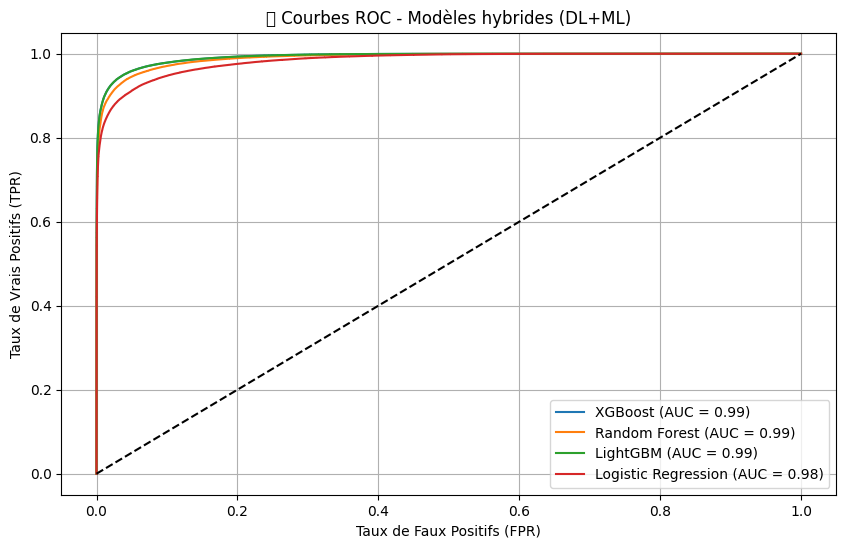

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# 🔹 Initialisation pour ROC
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test_fused)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")

# 🔹 Courbe ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('📈 Courbes ROC - Modèles hybrides (DL+ML)')
plt.legend()
plt.grid()
plt.show()

#  Confusion Matrice

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


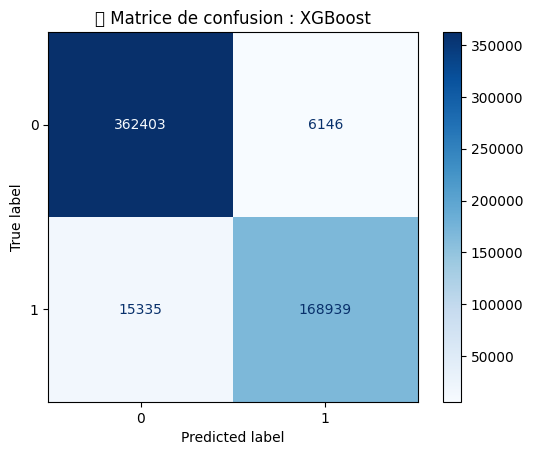

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


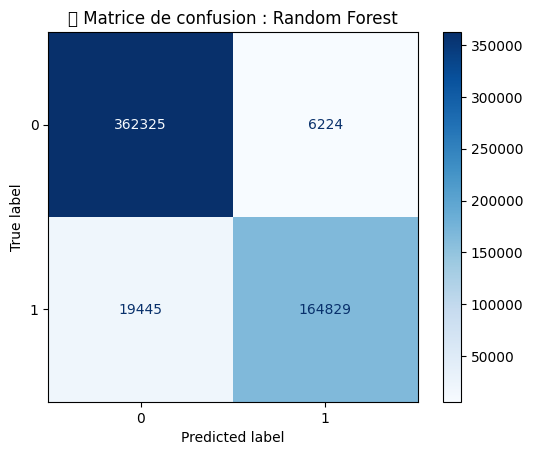

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


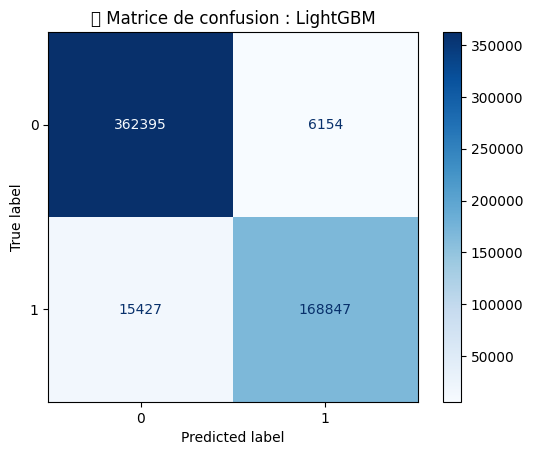

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


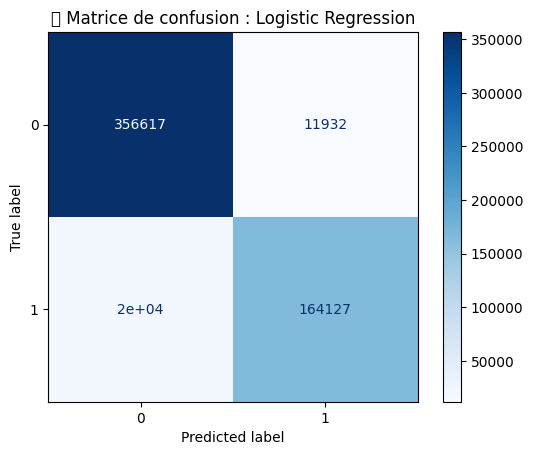

In [ ]:
# 🔹 Matrices de confusion pour chaque modèle
for name, model in models.items():
    y_pred = model.predict(X_test_fused)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'📊 Matrice de confusion : {name}')
    plt.show()

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# 🔹 Modèle XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100,
                              max_depth=5,
                              learning_rate=0.1,
                              use_label_encoder=False,
                              eval_metric='logloss')
xgb_model.fit(X_train_fused, y_train)

# 🔍 Prédictions
y_pred_xgb = xgb_model.predict(X_test_fused)
y_pred_prob_xgb = xgb_model.predict_proba(X_test_fused)[:, 1]




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:20:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# **Explainable AI**

100%|===================| 552797/552823 [47:58<00:00]       

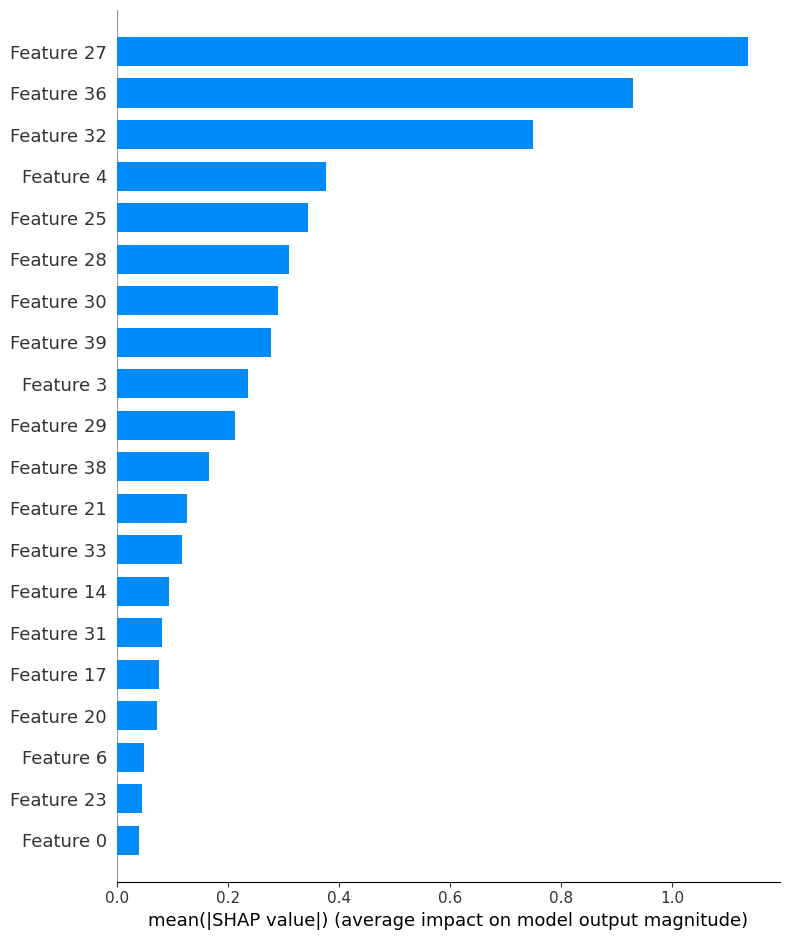

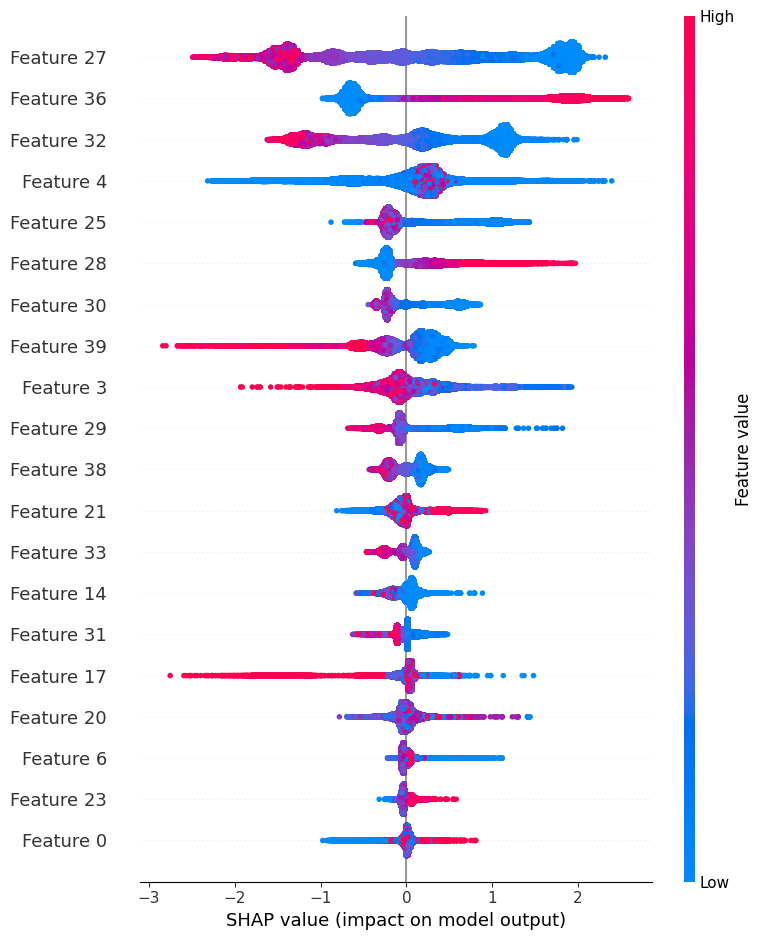

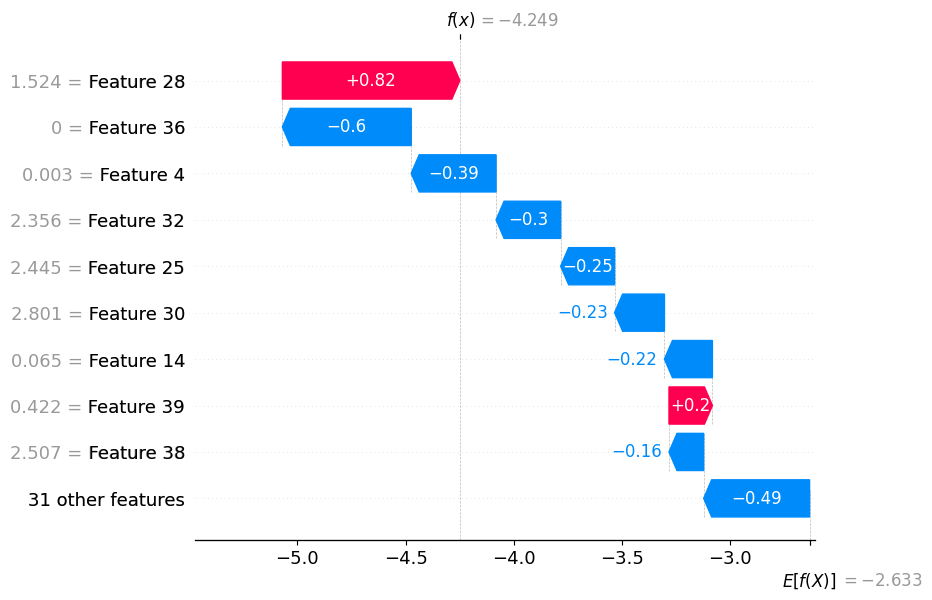

In [ ]:
import shap

# 🔹 Initialisation de l'explainer avec le modèle XGBoost
explainer_shap = shap.Explainer(xgb_model, X_train_fused)

# 🔹 Calcul des valeurs SHAP sur l'ensemble de test
shap_values = explainer_shap(X_test_fused)

# 🔹 Résumé global des features
shap.summary_plot(shap_values, X_test_fused, plot_type="bar")

# 🔹 Résumé détaillé (avec les points)
shap.summary_plot(shap_values, X_test_fused)

# 🔹 Explication d'une prédiction individuelle
shap.plots.waterfall(shap_values[0])

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2558c3d1540e2772ad360165853ec81181bd79e70a96809358fb33daa49b9280
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

# 🔹 Initialisation de LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_fused,
    feature_names=[f"feature_{i}" for i in range(X_train_fused.shape[1])],
    class_names=["Non-Fraud", "Fraud"],
    mode='classification'
)

# 🔹 Explication d'une instance
i = 0  # index de l'instance à expliquer
exp = explainer_lime.explain_instance(
    data_row=X_test_fused[i],
    predict_fn=xgb_model.predict_proba,
    num_features=10
)

# 🔹 Affichage de l’explication
exp.show_in_notebook(show_table=True)

In [ ]:
import pandas as pd

# 🔹 Création des DataFrames
df_train_fused = pd.DataFrame(X_train_fused)
df_train_fused["label"] = y_train.values

df_test_fused = pd.DataFrame(X_test_fused)
df_test_fused["label"] = y_test.values

# 🔹 Sauvegarde dans ton Drive (ou local)
df_train_fused.to_csv("/content/drive/MyDrive/archive/train_fusionne.csv", index=False)
df_test_fused.to_csv("/content/drive/MyDrive/archive/test_fusionne.csv", index=False)


In [ ]:
import joblib

# 🔹 Sauvegarde du modèle
joblib.dump(xgb_model, "/content/drive/MyDrive/archive/mon_xgboost.pkl")


['/content/drive/MyDrive/archive/mon_xgboost.pkl']

In [ ]:
import joblib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix
from lime.lime_tabular import LimeTabularExplainer

# --- 1. Sauvegarde des modèles ---
autoencoder_classifier.save('/content/drive/MyDrive/archive/models/autoencoder_classifier.h5')
encoder_model.save('/content/drive/MyDrive/archive/models/encoder_model.h5')
joblib.dump(xgb_model, '/content/drive/MyDrive/archive/models/xgboost_model.pkl')

# Sauvegarde de tous les modèles ML
for name, model in models.items():
    joblib.dump(model, f'/content/drive/MyDrive/archive/models/{name.lower().replace(" ", "_")}_model.pkl')

# --- 2. Sauvegarde des données ---
np.save('/content/drive/MyDrive/archive/processed/X_train_fused.npy', X_train_fused)
np.save('/content/drive/MyDrive/archive/processed/X_test_fused.npy', X_test_fused)
np.save('/content/drive/MyDrive/archive/processed/y_test.npy', y_test.values)

# Échantillon de données brutes pour le dashboard
df_balanced_new.sample(100).to_csv('/content/drive/MyDrive/archive/raw/data_sample.csv', index=False)

# --- 3. Sauvegarde des métriques et visualisations ---
# ROC Curve
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_fused)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/archive/assets/images/roc_curves.png')
plt.close()

# Matrices de confusion
for name, model in models.items():
    y_pred = model.predict(X_test_fused)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.savefig(f'/content/drive/MyDrive/archive/assets/images/confusion_matrix_{name.lower().replace(" ", "_")}.png')
    plt.close()

# --- 4. Sauvegarde des explications ---
# SHAP
np.save('/content/drive/MyDrive/archive/assets/shap_values.npy', shap_values.values)

# LIME (exemple pour une instance)
explainer_lime = LimeTabularExplainer(
    training_data=X_train_fused,
    feature_names=[f"feature_{i}" for i in range(X_train_fused.shape[1])],
    class_names=["Non-Fraud", "Fraud"],
    mode='classification'
)
exp = explainer_lime.explain_instance(X_test_fused[0], xgb_model.predict_proba, num_features=10)
exp.save_to_file('/content/drive/MyDrive/archive/assets/lime_explanation.html')

# --- 5. Métadonnées ---
# Noms des features et rapports de classification
with open('/content/drive/MyDrive/archive/assets/feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

reports = {name: classification_report(y_test, model.predict(X_test_fused), output_dict=True) for name, model in models.items()}
with open('/content/drive/MyDrive/archive/assets/classification_reports.pkl', 'wb') as f:
    pickle.dump(reports, f)

print("✅ Tous les assets ont été sauvegardés !")